In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
import keras.backend as K
import keras.utils
import tensorflow as tf

from tqdm import tqdm
import chipwhisperer as cw
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_5 as palette
import itertools
import datetime
import time
import h5py

In [2]:
Sbox = [
0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]

HW       = np.array([ 0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8 ]).astype(np.int8)

In [3]:
simul_trace = []
for j in range(20000):
    tmp = []
    for i in range(22):
        tmp.append(random.randint(0, 255))
    simul_trace.append(tmp)
simul_trace = np.array(simul_trace)

In [4]:
simul_pt =[]
for j in range(20000):
    tmp = []
    tmp.append(random.randint(0, 255))
    tmp.append(random.randint(0, 255))
    simul_pt.append(tmp)
simul_pt = np.array(simul_pt)

In [5]:
simul_key = []
key = [0x82, 0xAE]
for j in range(20000):
    simul_key.append(key)
simul_key = np.array(simul_key)       

In [6]:
simul_pt = simul_pt.reshape(20000, 2)
simul_key = simul_key.reshape(20000, 2)

In [7]:
print(simul_trace.shape)
print(simul_pt.shape)
print(simul_key.shape)

(20000, 22)
(20000, 2)
(20000, 2)


In [8]:
for i in range(20000):
    # MS_Box 생성
    MS_box = list(range(256))
    for j in range(256):
        MS_box[j ^ simul_trace[i][20]] = Sbox[j] ^ simul_trace[i][21]
    
    simul_trace[i, 2] = np.array(MS_box)[simul_key[i, 0] ^ simul_pt[i, 0] ^ simul_trace[i][20]]
    simul_trace[i, 4] = np.array(MS_box)[simul_key[i, 1] ^ simul_pt[i, 1] ^ simul_trace[i][20]]

simul_trace = simul_trace[:, :-2]
print(simul_trace.shape)

(20000, 20)


In [9]:
simul_trace = HW[simul_trace[:]]
simul_trace = simul_trace + 5
simul_trace[:, 0] = 2.3
simul_trace[:, 3] = 1.1
simul_trace[:, 6] = 1.2
simul_trace[:, 9] = 2.2
simul_trace[:, 12] = 2.0
simul_trace[:, 15] = 1.7
simul_trace[:, 18] = 2.1

In [10]:
noise = np.random.normal(0, 1.5, size=(20000, 20))
simul_trace = simul_trace + noise

In [11]:
simul_trace.shape

(20000, 20)

In [12]:
print(simul_trace[0])

[ 2.17238949  7.79414497 10.71072214  1.4539298  10.19304772  9.52271682
 -0.06733819  7.24033169  8.53369886  4.4542657   8.84165121 13.76179574
  0.3656709   9.524092   10.29445956 -1.86261955  7.74948898  7.95959642
  4.26759665  8.29117275]


In [13]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(simul_trace[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, simul_trace[i], color=color)
show(p)

Loading BokehJS ...

In [14]:
# 전처리 파형 중 일부사용
simul_trace_normal = np.array(simul_trace[:], dtype='float64')
for i in range(len(simul_trace)):
    simul_trace_normal[i] -= simul_trace_normal[i].mean()
    MIN = min(simul_trace_normal[i])
    MAX = max(simul_trace_normal[i])
    simul_trace_normal[i] = ((simul_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2
    
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(simul_trace_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, simul_trace_normal[i], color=color)
show(p)

Loading BokehJS ...

In [15]:
a = simul_trace[:, 0:4]
b = simul_trace[:, 4:8]

In [16]:
for i in range(4):
    for j in range(4):
        if (i==0 and j==0):
            so_simul_trace = np.array([abs(a[:, i] - b[:, j])])
        else:
            tmp = np.array([abs(a[:, i] - b[:, j])])
            so_simul_trace = np.concatenate((so_simul_trace, tmp), axis=0)
so_simul_trace = np.transpose(so_simul_trace)
#so_simul_trace = np.fabs(so_simul_trace)
print(so_simul_trace.shape)

(20000, 16)


In [17]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(so_simul_trace[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, so_simul_trace[i], color=color)
show(p)

Loading BokehJS ...

In [18]:
# 전처리 파형 중 일부사용
so_simul_trace_normal = np.array(so_simul_trace[:], dtype='float64')
for i in range(len(so_simul_trace)):
    so_simul_trace_normal[i] -= so_simul_trace_normal[i].mean()
    MIN = min(so_simul_trace_normal[i])
    MAX = max(so_simul_trace_normal[i])
    so_simul_trace_normal[i] = ((so_simul_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2
    
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(so_simul_trace_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, so_simul_trace_normal[i], color=color)
show(p)

Loading BokehJS ...

In [19]:
def correlation(X, Y):
    X = X - np.mean(X, axis=0)
    Y = Y - np.mean(Y, axis=0)
    return np.sum(X * Y, axis=0) / (np.sqrt(np.sum(np.square(X), axis=0)) * np.sqrt(np.sum(np.square(Y), axis=0)))

def test(trace, plain, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(65536)):
        IntermediateValue = HW[(np.array(Sbox)[(plain[:, 0] ^ (GuessKey & 0xff))] ^ np.array(Sbox)[(plain[:, 1] ^ (GuessKey >> 8))]).astype(int)]
        IntermediateValue = IntermediateValue.reshape(20000, 1)
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

100%|███████████████████████████████████████████████████████████████████████████| 65536/65536 [03:30<00:00, 311.27it/s]


Analyzed Key        : 0xae82
Ratio               : [2.8879837704754623]
Max Correlation     : 0.09892912544405924


[ MaxPeak Figure ]


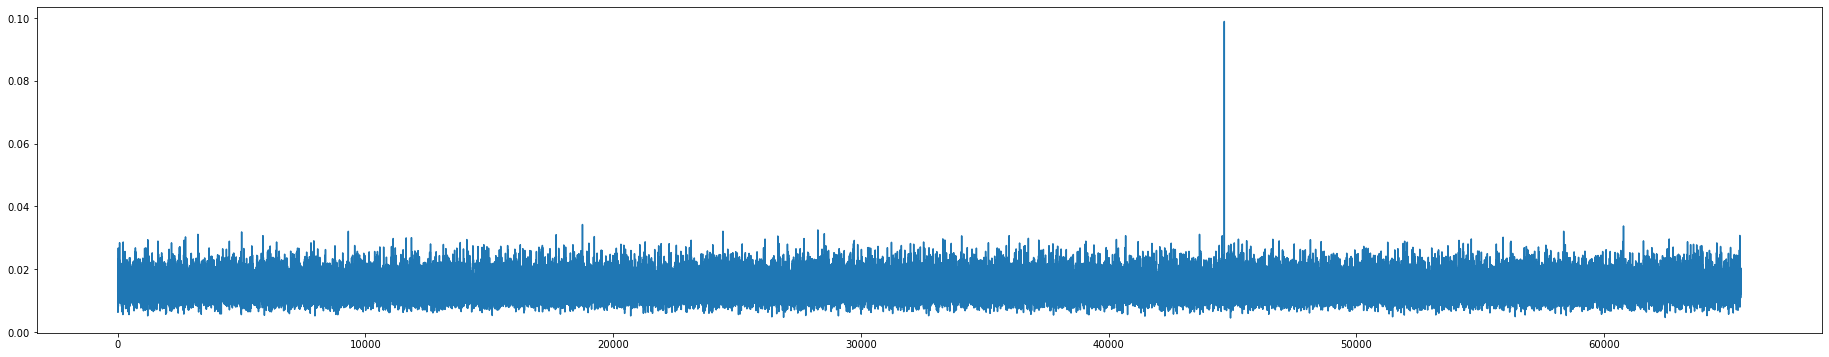



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [20]:
AnalyzedKey = []

for targetByte in range(2, 3):
    key, Ratio, KeyCorrs, MaxPeak = test(so_simul_trace_normal, simul_pt, 0)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_simul_trace_normal[0]))
    p.line(x_range, so_simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [124]:
def bit_test(trace, plain, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(65536)):
        IntermediateValue = (np.array(Sbox)[(plain[:, 0] ^ (GuessKey & 0xff))] ^ np.array(Sbox)[(plain[:, 1] ^ (GuessKey >> 8))]) & 1
        IntermediateValue = IntermediateValue.reshape(20000, 1)
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

100%|███████████████████████████████████████████████████████████████████████████| 65536/65536 [04:19<00:00, 252.79it/s]


Analyzed Key        : 0xae82
Ratio               : [2.7393036491268794]
Max Correlation     : 0.09534980850347305


[ MaxPeak Figure ]


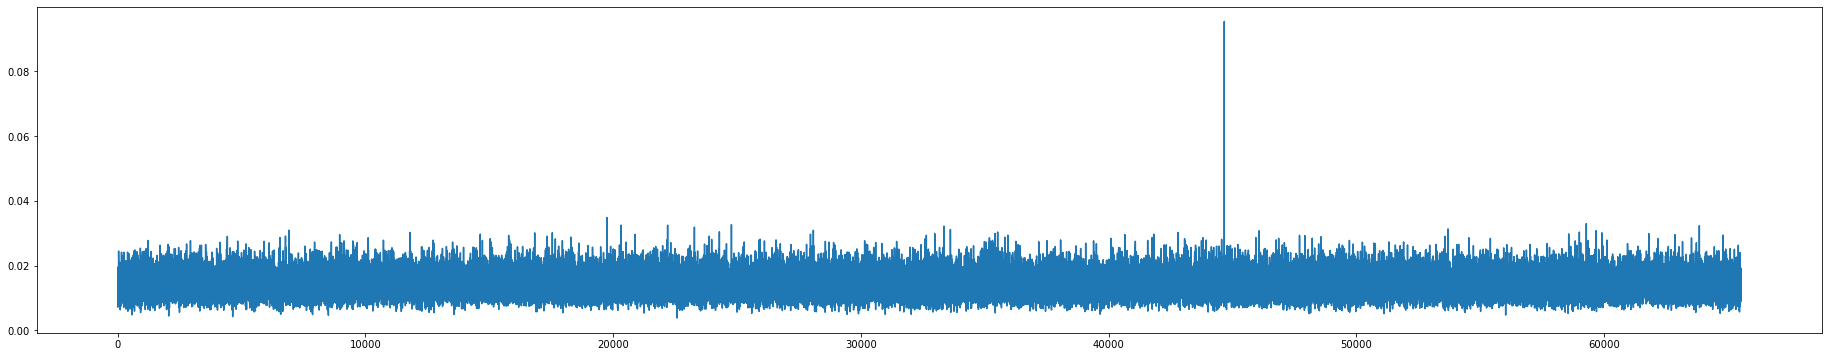



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|███████████████████████████████████████████████████████████████████████████| 65536/65536 [04:20<00:00, 251.24it/s]


Analyzed Key        : 0xae82
Ratio               : [2.7393036491268794]
Max Correlation     : 0.09534980850347305


[ MaxPeak Figure ]


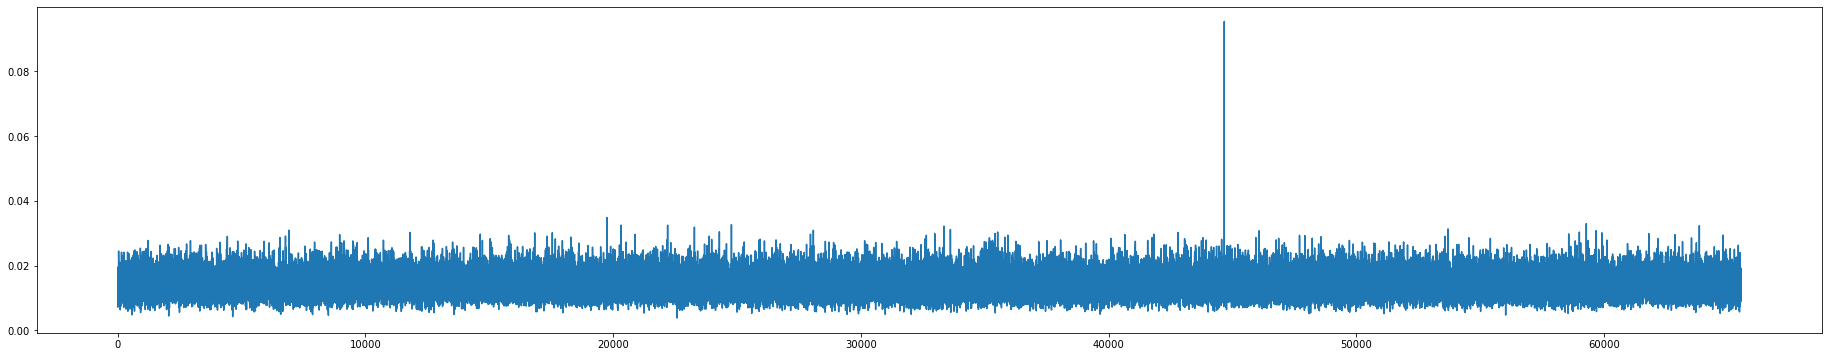



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|███████████████████████████████████████████████████████████████████████████| 65536/65536 [04:27<00:00, 245.28it/s]


Analyzed Key        : 0xae82
Ratio               : [2.7393036491268794]
Max Correlation     : 0.09534980850347305


[ MaxPeak Figure ]


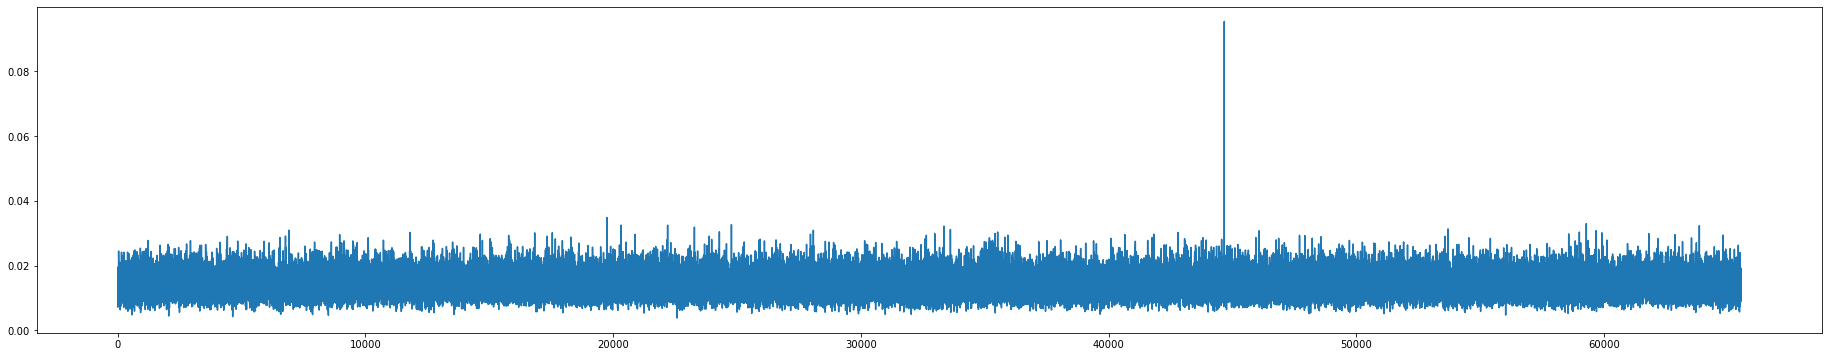



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|███████████████████████████████████████████████████████████████████████████| 65536/65536 [04:30<00:00, 242.20it/s]


Analyzed Key        : 0xae82
Ratio               : [2.7393036491268794]
Max Correlation     : 0.09534980850347305


[ MaxPeak Figure ]


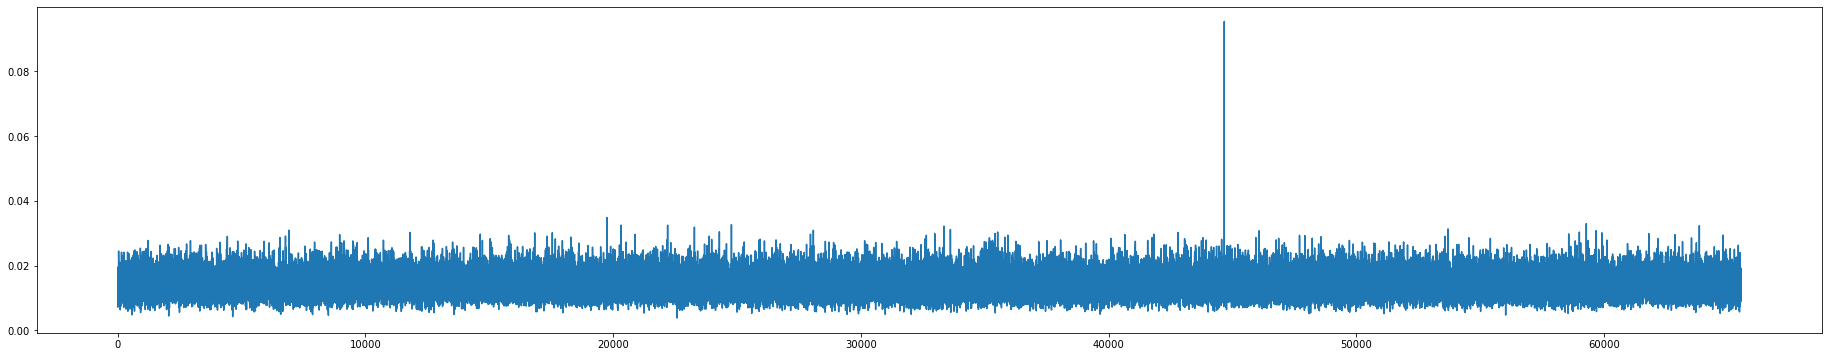



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|███████████████████████████████████████████████████████████████████████████| 65536/65536 [04:21<00:00, 250.96it/s]


Analyzed Key        : 0xae82
Ratio               : [2.7393036491268794]
Max Correlation     : 0.09534980850347305


[ MaxPeak Figure ]


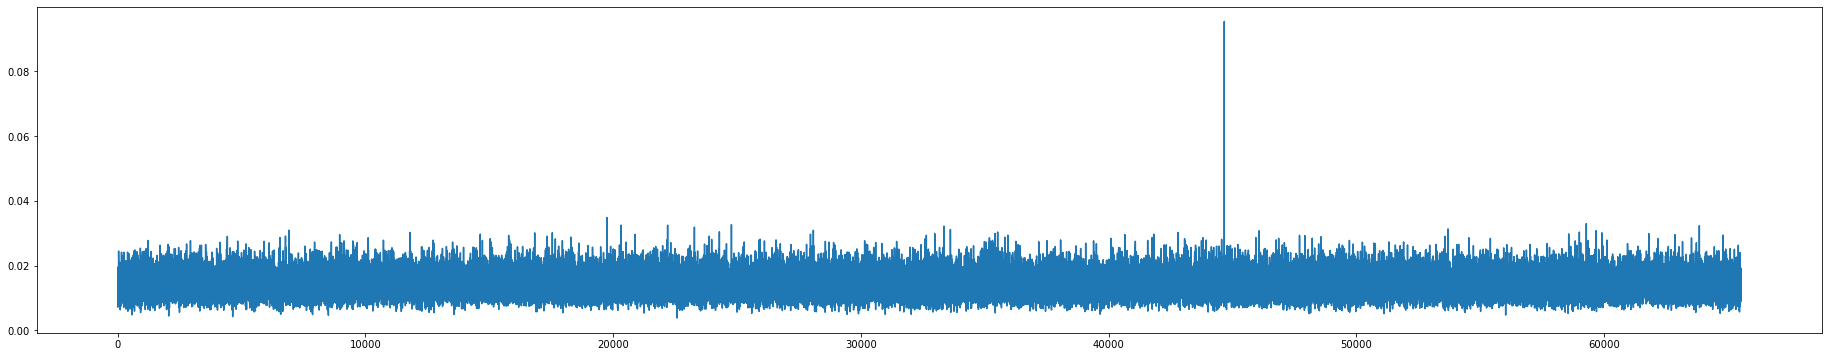



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

 10%|███████▍                                                                    | 6457/65536 [00:27<04:09, 236.49it/s]


KeyboardInterrupt: 

In [125]:
AnalyzedKey = []

for targetByte in range(0, 8):
    key, Ratio, KeyCorrs, MaxPeak = bit_test(so_simul_trace_normal, simul_pt, targetByte)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_simul_trace_normal[0]))
    p.line(x_range, so_simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [123]:
AnalyzedKey = []

for targetByte in range(2, 3):
    key, Ratio, KeyCorrs, MaxPeak = test(simul_trace_normal, simul_pt, 0)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(simul_trace_normal[0]))
    p.line(x_range, simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

 66%|█████████████████████████████████████████████████▏                         | 42943/65536 [03:54<02:03, 182.87it/s]


KeyboardInterrupt: 

In [315]:
def FO_test(trace, plain, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(256)):
        IntermediateValue = HW[np.array(Sbox)[(plain[:, 0] ^ GuessKey).astype(int)]]
        IntermediateValue = IntermediateValue.reshape(20000, 1)
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 160.30it/s]


Analyzed Key        : 0xc2
Ratio               : [1.0627280343627217]
Max Correlation     : 0.027331629418704477


[ MaxPeak Figure ]


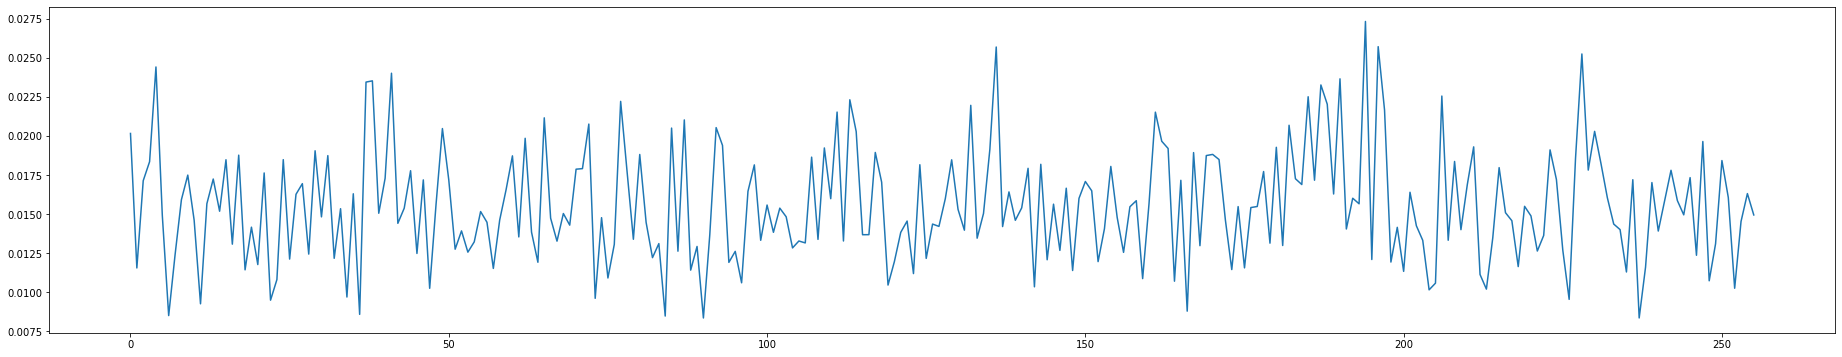



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [316]:
AnalyzedKey = []

for targetByte in range(2, 3):
    key, Ratio, KeyCorrs, MaxPeak = FO_test(simul_trace_normal, simul_pt, 0)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(simul_trace_normal[0]))
    p.line(x_range, simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [335]:
target_byte = 2
All_difference = []

def simul_analysis_MLP(m, Init, traces, pts, tr_num, num_keycandi, result_type, num_epochs, batch_size, right_key):
    right_candi = 0
    right_candida = 0
    accuracies = []
    losses     = []
    
    best_acc = 0
    best_loss = 100
    
    val_right_candi = 0
    val_right_candida = 0
    val_accuracies = []
    val_losses     = []
    
    val_best_acc = 0
    val_best_loss = 100
    
    train_num = int(tr_num * 0.8)
    
    for k in tqdm(range(num_keycandi)):
        m.set_weights(Init)

        hypothesis = np.array(Sbox)[(pts[:, 0] ^ ((0xae80 + k) & 0xff)).astype(int)] ^ np.array(Sbox)[(pts[:, 1] ^ ((0xae80 + k) >> 8)).astype(int)]
        #target = sum([hypothesis & (1 << i) > 0 for i in range(8)])
        #target = keras.utils.to_categorical(target, 9)
        #target = ((hypothesis >> 7) & 1).astype(float)
        #target = (hypothesis & 1).astype(float)
        #target = keras.utils.to_categorical(target, 2)
        target = np.array([(hypothesis & 1).astype(float), ((hypothesis & 2) >> 1).astype(float),((hypothesis & 4) >> 2).astype(float),((hypothesis & 8) >> 3).astype(float),((hypothesis & 16) >> 4).astype(float),((hypothesis & 32) >> 5).astype(float),((hypothesis & 64) >> 6).astype(float),((hypothesis & 128) >> 7).astype(float)])
        target = np.transpose(target)
        target = np.reshape(target, (traces.shape[0], 8))
        
        
        m.fit(x = traces[:train_num], y = target[:train_num], validation_data = (traces[train_num:tr_num], target[train_num:tr_num]), epochs = num_epochs, batch_size = batch_size, verbose = 0)

        accuracies.append(m.history.history['accuracy'])
        if best_acc < m.history.history['accuracy'][num_epochs - 1]:
            best_acc = m.history.history['accuracy'][num_epochs - 1]
            right_candi = k
            
        val_accuracies.append(m.history.history['val_accuracy'])
        if k == 0:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        if val_best_acc < m.history.history['val_accuracy'][num_epochs - 1]:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        
        losses.append(m.history.history['loss'])
        if best_loss > m.history.history['loss'][num_epochs - 1]:
            best_loss = m.history.history['loss'][num_epochs - 1]
            right_candida = k
        
        val_losses.append(m.history.history['val_loss'])
        if k == 0:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
        if val_best_loss > m.history.history['val_loss'][num_epochs - 1]:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
            
    print("Right candidate: ", hex(right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, right_candi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_candi + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_candi], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    for k in range(val_right_candi + 1, num_keycandi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    plt.plot(val_accuracies[~val_right_candi], color = 'black', label = 'wrong key')
    plt.plot(val_accuracies[val_right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_candida - 1):
        plt.plot(losses[k], color = 'black', label = None)
    for k in range(right_candida + 1, num_keycandi - 1):
        plt.plot(losses[k], color = 'black', label = None)
    plt.plot(losses[~right_candida], color = 'black', label = 'wrong key')
    plt.plot(losses[right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candida - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    for k in range(val_right_candida + 1, num_keycandi - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    plt.plot(val_losses[~val_right_candida], color = 'black', label = 'wrong key')
    plt.plot(val_losses[val_right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()

In [37]:
class Stretch_Sigmoid(layers.Activation):
    def __init__(self, activation, **kwargs):
        super(Stretch_Sigmoid, self).__init__(activation, **kwargs)
        self.__name__ = 'stretch_sigmoid'

def stretch_sigmoid(x, beta=1):
    return K.sigmoid(beta * x)

keras.utils.get_custom_objects().update({'stretch_sigmoid': Stretch_Sigmoid(stretch_sigmoid)})

In [35]:
class Custom(layers.Activation):
    def __init__(self, activation, **kwargs):
        super(Custom, self).__init__(activation, **kwargs)
        self.__name__ = 'Custom'

def custom(x):
    return K.maximum(K.sqrt(x),0)

keras.utils.get_custom_objects().update({'Custom': Custom(custom)})

In [344]:
def simul_build_MLP(points_len, hidden_nodes = [300, 300, 300], dropout_layers = [0.2, 0.2, 0.2],
              optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)):
    model = keras.models.Sequential()
    model.add(layers.BatchNormalization())
    
    # dense 레이어 추가
    model.add(layers.Dense(hidden_nodes[0], kernel_initializer = 'he_normal', input_dim = points_len, name = 'dense_1'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    
    if dropout_layers[0] != 0:
        model.add(layers.Dropout(dropout_layers[0], name = 'dropout_1'))

    for i, num_units in enumerate(hidden_nodes[1:]):
        model.add(layers.Dense(num_units, kernel_initializer = 'he_normal', name = 'dense_{}'.format(i + 2)))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        if dropout_layers[i + 1] != 0:
            model.add(layers.Dropout(dropout_layers[i + 1], name = 'dropout_{}'.format(i + 2)))

    model.add(layers.Dense(8, kernel_initializer = 'he_normal', name = 'output'.format(len(hidden_nodes) + 1)))
    model.add(layers.Activation('stretch_sigmoid'))
    
    z = layers.Input(shape = (points_len, ), name = 'input')
    sequence = model(z)

    m = keras.models.Model(z, sequence, name = 'MLSCA')
    m.summary(80)
    
    m.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    return m

  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

20000
============= 20000 =============
Model: "MLSCA"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  [(None, 20)]                    0           
________________________________________________________________________________
sequential_81 (Sequential)          (None, 8)                       2728        
Total params: 2,728
Trainable params: 2,528
Non-trainable params: 200
________________________________________________________________________________
Training started:  2021-10-05 21:57:16.486874


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [06:50<00:00,  3.21s/it]


Right candidate:  0x1b


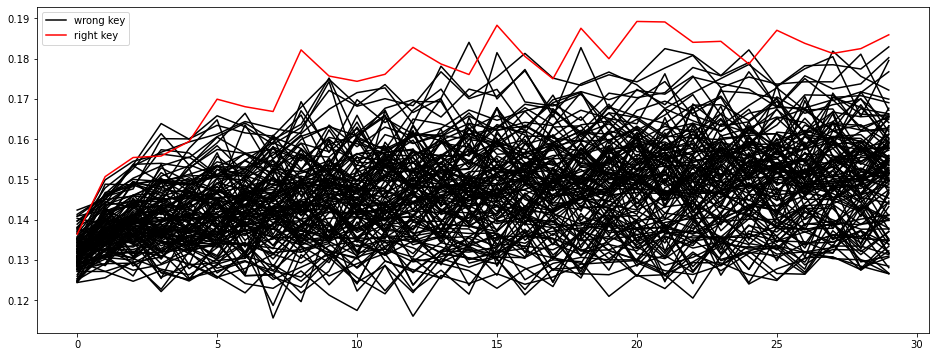

Right candidate:  0x24


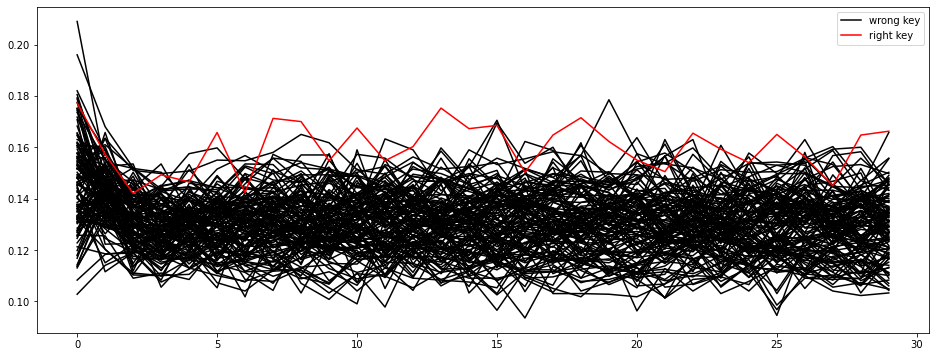

Right candidate:  0x2


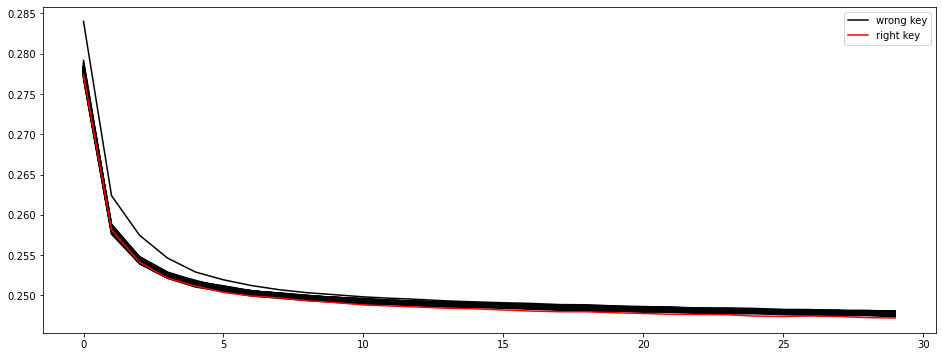

Right candidate:  0x2


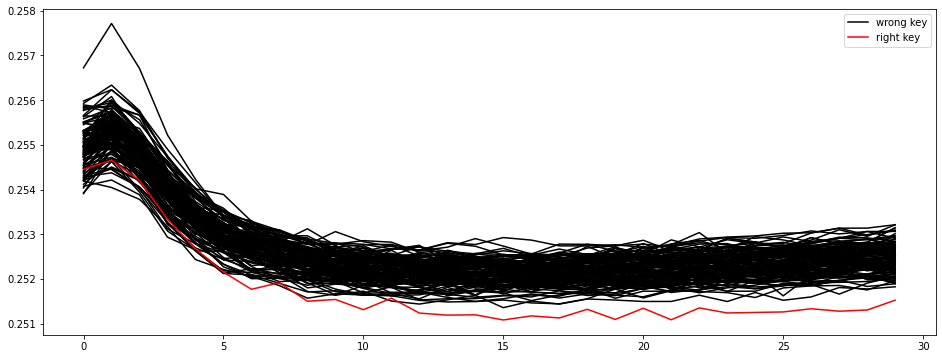

Training ended:  2021-10-05 22:04:08.869910
Elapsed 412.3830358982086


In [345]:
train_num = simul_trace_normal.shape[0]
print(train_num)

print("============= {} =============".format(train_num))
rand_idx = np.arange(0, train_num) # 반복부분
np.random.shuffle(rand_idx)

simul_T_attack = simul_trace_normal[rand_idx]
simul_P_attack = simul_pt[rand_idx]

m = simul_build_MLP(simul_trace_normal.shape[1], [80], [0])
#m = simul_build_CNN(simul_trace_normal.shape[1], [8, 16, 32])

Init = m.get_weights()

# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

simul_analysis_MLP(m, Init, simul_T_attack, simul_P_attack, train_num, 128, 'HW', 30, 100, 0xE0)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

In [262]:
import larq as lq

In [96]:
kwargs = dict(input_quantizer=None,
              kernel_quantizer="ste_tern",
              kernel_constraint="weight_clip",
              use_bias=True)

In [119]:
def BNN_build_MLP(points_len, hidden_nodes = [300, 300, 300], dropout_layers = [0.2, 0.2, 0.2],
              optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)):
    model = keras.models.Sequential()
    model.add(layers.BatchNormalization())
    
    # dense 레이어 추가
    model.add(lq.layers.QuantDense(hidden_nodes[0],
                                   **kwargs,
                                   input_dim = points_len, name = 'dense_1'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    
    if dropout_layers[0] != 0:
        model.add(layers.Dropout(dropout_layers[0], name = 'dropout_1'))

    for i, num_units in enumerate(hidden_nodes[1:]):
        model.add(lq.layers.QuantDense(num_units, **kwargs, name = 'dense_{}'.format(i + 2)))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        if dropout_layers[i + 1] != 0:
            model.add(layers.Dropout(dropout_layers[i + 1], name = 'dropout_{}'.format(i + 2)))

    model.add(lq.layers.QuantDense(8, **kwargs, name = 'output'.format(len(hidden_nodes) + 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('stretch_sigmoid'))
    
    z = layers.Input(shape = (points_len, ), name = 'input')
    sequence = model(z)

    m = keras.models.Model(z, sequence, name = 'MLSCA')
    m.summary(80)
    
    m.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    return m

20000
============= 20000 =============
Model: "MLSCA"

  0%|                                                                                          | 0/128 [00:00<?, ?it/s]


________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  [(None, 20)]                    0           
________________________________________________________________________________
sequential_32 (Sequential)          (None, 8)                       2760        
Total params: 2,760
Trainable params: 2,544
Non-trainable params: 216
________________________________________________________________________________
Training started:  2021-10-04 22:08:25.921400


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [12:59<00:00,  6.09s/it]


Right candidate:  0x7e


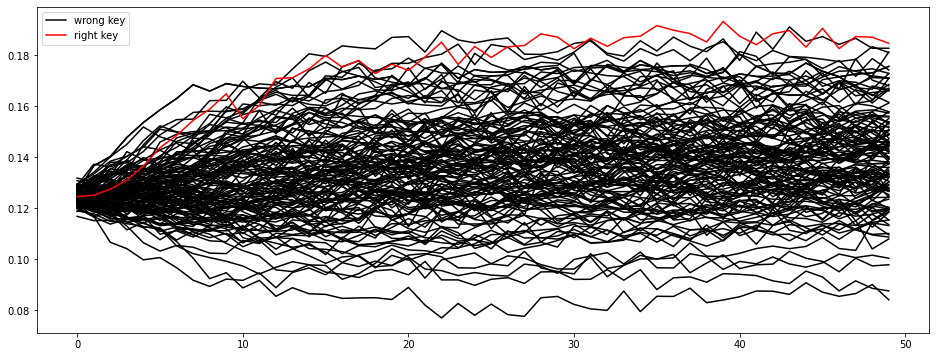

Right candidate:  0x67


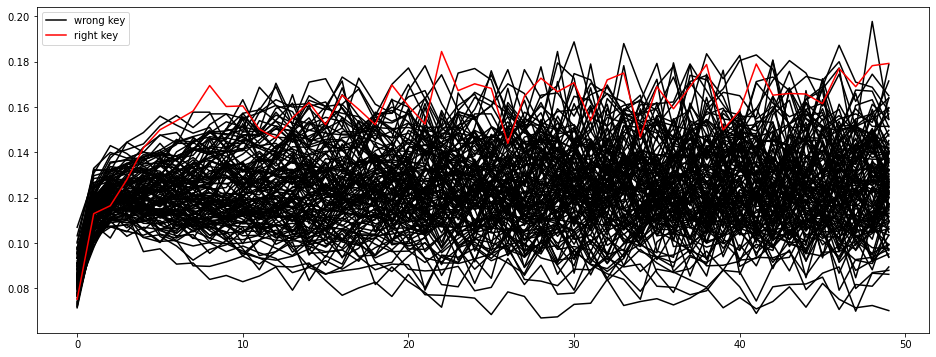

Right candidate:  0x2


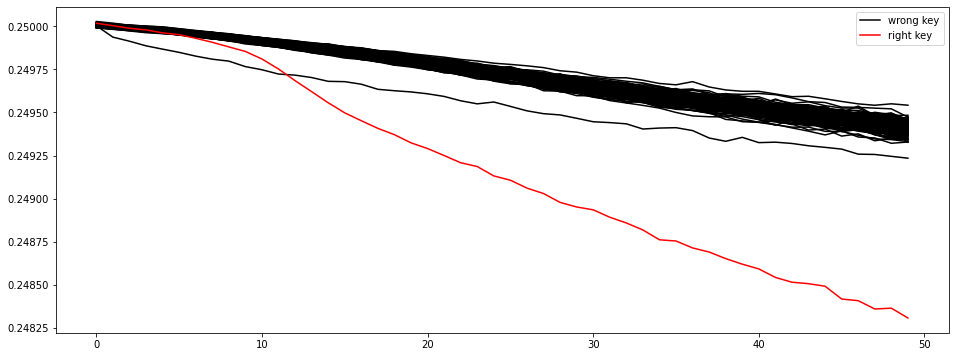

Right candidate:  0x2


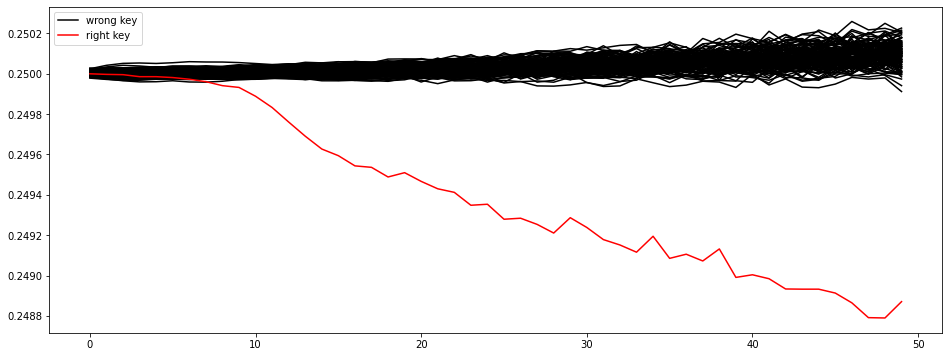

Training ended:  2021-10-04 22:21:26.746604
Elapsed 780.8242061138153


In [122]:
train_num = simul_trace_normal.shape[0]
print(train_num)

print("============= {} =============".format(train_num))
rand_idx = np.arange(0, train_num) # 반복부분
np.random.shuffle(rand_idx)

simul_T_attack = simul_trace_normal[rand_idx]
simul_P_attack = simul_pt[rand_idx]

m = BNN_build_MLP(simul_trace_normal.shape[1], [80], [0])

Init = m.get_weights()

# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

simul_analysis_MLP(m, Init, simul_T_attack, simul_P_attack, train_num, 128, 'HW', 50, 100, 0xE0)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

In [26]:
target_byte = 2
All_difference = []

def simul_analysis_MLP_AT(m, Init, traces, pts, tr_num, num_keycandi, result_type, num_epochs, batch_size, right_key):
    right_candi = 0
    right_candida = 0
    accuracies = []
    losses     = []
    
    best_acc = 0
    best_loss = 100
    
    val_right_candi = 0
    val_right_candida = 0
    val_accuracies = []
    val_losses     = []
    
    val_best_acc = 0
    val_best_loss = 100
    
    train_num = int(tr_num * 0.8)
    
    for k in tqdm(range(num_keycandi)):
        m.set_weights(Init)
        
        hypothesis = np.array(Sbox)[(pts[:, 0] ^ ((0xae80 + k) & 0xff)).astype(int)] ^ np.array(Sbox)[(pts[:, 1] ^ ((0xae80 + k) >> 8)).astype(int)]
        #hypothesis = np.array(Sbox)[(pts[:] ^ k).astype(int)]
        #target = sum([hypothesis & (1 << i) > 0 for i in range(8)])
        #target = keras.utils.to_categorical(target, 9)
        #target = ((hypothesis >> 7) & 1).astype(float)
        #target = (hypothesis & 1).astype(float)
        #target = keras.utils.to_categorical(target, 2)
        target = np.array([(hypothesis & 1).astype(float), ((hypothesis & 2) >> 1).astype(float),((hypothesis & 4) >> 2).astype(float),((hypothesis & 8) >> 3).astype(float),((hypothesis & 16) >> 4).astype(float),((hypothesis & 32) >> 5).astype(float),((hypothesis & 64) >> 6).astype(float),((hypothesis & 128) >> 7).astype(float)])
        target = np.transpose(target)
        target = np.reshape(target, (traces.shape[0], 8))
        
        
        m.fit(x = traces[:train_num], y = target[:train_num], validation_data = (traces[train_num:tr_num], target[train_num:tr_num]), epochs = num_epochs, batch_size = batch_size, verbose = 0)

        accuracies.append(m.history.history['accuracy'])
        if best_acc < m.history.history['accuracy'][num_epochs - 1]:
            best_acc = m.history.history['accuracy'][num_epochs - 1]
            right_candi = k
            
        val_accuracies.append(m.history.history['val_accuracy'])
        if k == 0:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        if val_best_acc < m.history.history['val_accuracy'][num_epochs - 1]:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        
        losses.append(m.history.history['loss'])
        if best_loss > m.history.history['loss'][num_epochs - 1]:
            best_loss = m.history.history['loss'][num_epochs - 1]
            right_candida = k
        
        val_losses.append(m.history.history['val_loss'])
        if k == 0:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
        if val_best_loss > m.history.history['val_loss'][num_epochs - 1]:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
            
    print("Right candidate: ", hex(right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, right_candi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_candi + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_candi], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    for k in range(val_right_candi + 1, num_keycandi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    plt.plot(val_accuracies[~val_right_candi], color = 'black', label = 'wrong key')
    plt.plot(val_accuracies[val_right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_candida - 1):
        plt.plot(losses[k], color = 'black', label = None)
    for k in range(right_candida + 1, num_keycandi - 1):
        plt.plot(losses[k], color = 'black', label = None)
    plt.plot(losses[~right_candida], color = 'black', label = 'wrong key')
    plt.plot(losses[right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candida - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    for k in range(val_right_candida + 1, num_keycandi - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    plt.plot(val_losses[~val_right_candida], color = 'black', label = 'wrong key')
    plt.plot(val_losses[val_right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()

In [27]:
def build_SelfAattention_with_MLP(points_len):
    input_layer = layers.Input(shape = (points_len, ))
    #bat_input = layers.BatchNormalization()(input_layer)
    #attention_probs_1 = layers.Dense(points_len, activation='softmax')(input_layer)
    #attention_mul_1 = layers.multiply([input_layer, attention_probs_1])
    Dense_1 = layers.Dense(50, activation = 'relu')(input_layer)
    
    attention_probs_2 = layers.Dense(50, activation='softmax')(Dense_1)
    attention_mul_2 = layers.multiply([Dense_1, attention_probs_2])
    Dense_2 = layers.Dense(25, activation = 'relu')(attention_mul_2)
    y = layers.Dense(1, activation = 'sigmoid')(Dense_2)
    
    return tf.keras.Model(inputs=[input_layer], outputs=y)

  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

20000
============= 20000 =============
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 50)           1050        input_5[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 50)           2550        dense_16[0][0]                   
__________________________________________________________________________________________________
multiply_4 (Multiply)           (None, 50)           0           dense_16[0][0]                   
                                               

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [03:39<00:00,  1.72s/it]


Right candidate:  0x2


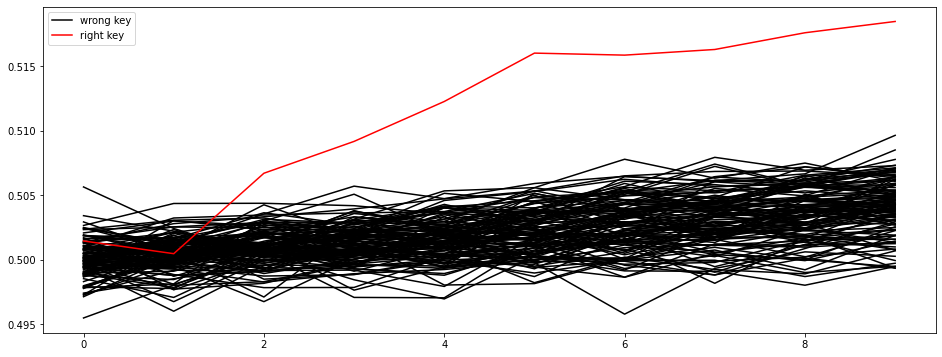

Right candidate:  0x2


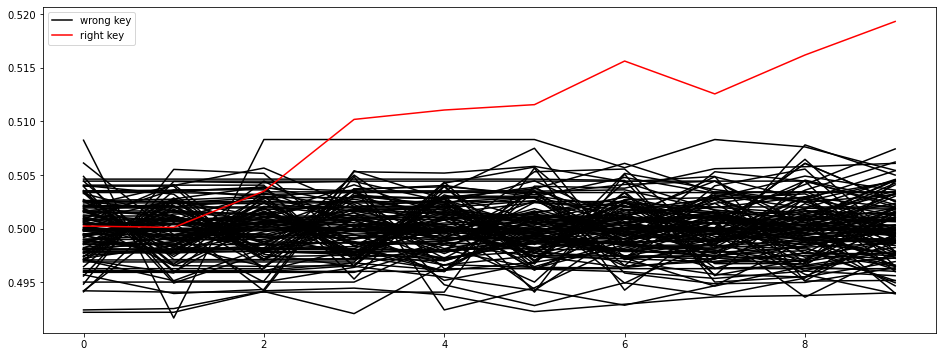

Right candidate:  0x2


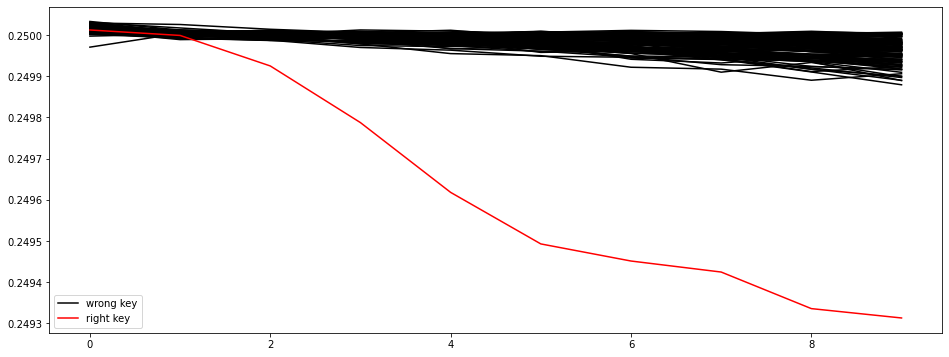

Right candidate:  0x2


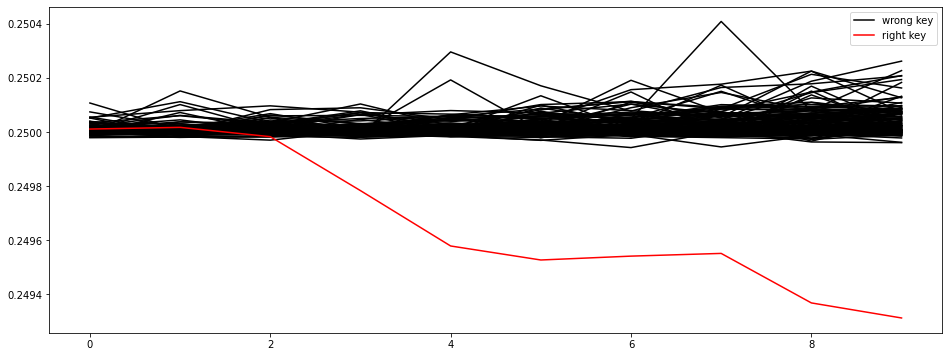

Training ended:  2022-08-18 15:02:51.966136
Elapsed 221.31386351585388


In [29]:
with tf.device("/device:GPU:0"):
    train_num = simul_trace_normal.shape[0]
    print(train_num)
    
    print("============= {} =============".format(train_num))
    rand_idx = np.arange(0, train_num) # 반복부분
    np.random.shuffle(rand_idx)
    
    simul_T_attack = simul_trace_normal[rand_idx]
    simul_P_attack = simul_pt[rand_idx]
    
    m = build_SelfAattention_with_MLP(simul_trace_normal.shape[1])
    m.summary()
    m.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    Init = m.get_weights()
    
    # 학습 시작 시간 측정
    print("Training started: ", datetime.datetime.now())
    start = time.time()
    
    simul_analysis_MLP_AT(m, Init, simul_T_attack, simul_P_attack, train_num, 128, 'HW', 10, 50, 0xE0)
    
    # 학습 종료 시간 측정 및 소요 시간 계산
    elapsed = time.time() - start
    print("Training ended: ", datetime.datetime.now())
    print("Elapsed", elapsed)

In [30]:
def build_MLP_0(points_len):
    input_layer = layers.Input(shape = (points_len, ))
    #bat_input = layers.BatchNormalization()(input_layer)
    #attention_probs_1 = layers.Dense(points_len, activation='softmax')(input_layer)
    #attention_mul_1 = layers.multiply([input_layer, attention_probs_1])
    Dense_1 = layers.Dense(50, activation = 'relu')(input_layer)
    
    Dense_2 = layers.Dense(50, activation='relu')(Dense_1)
    Dense_3 = layers.Dense(25, activation = 'relu')(Dense_2)
    y = layers.Dense(1, activation = 'sigmoid')(Dense_3)
    
    return tf.keras.Model(inputs=[input_layer], outputs=y)

  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

20000
============= 20000 =============
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 26        
Total params: 4,901
Trainable params: 4,901
Non-trainable params: 0
_________________________________________________________________
Training started:  2022-08-18 15:03:45.892239


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [03:27<00:00,  1.62s/it]


Right candidate:  0x2


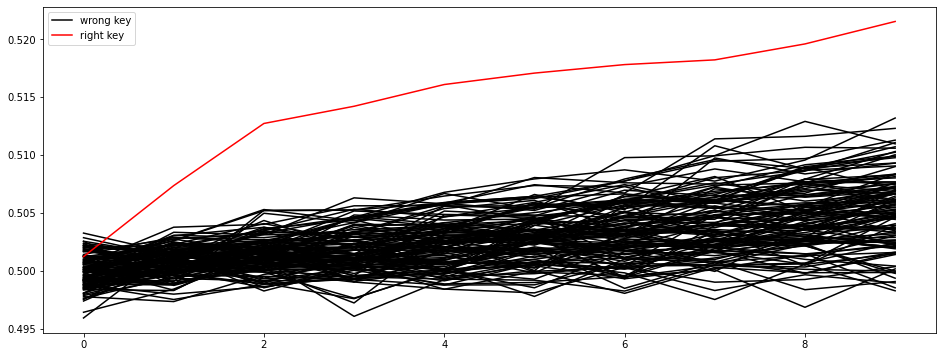

Right candidate:  0x2


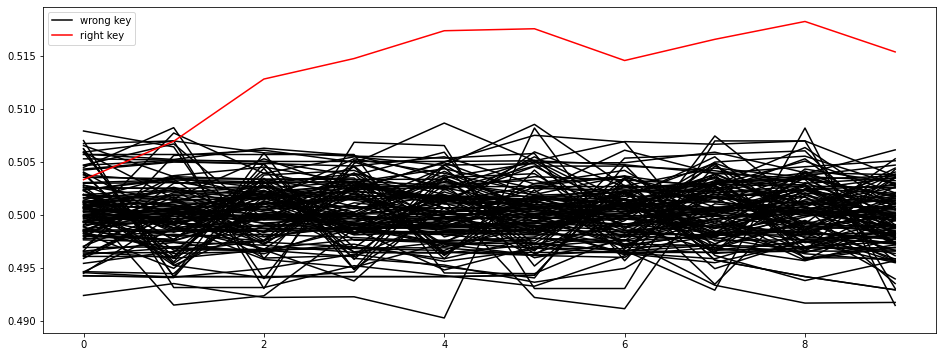

Right candidate:  0x2


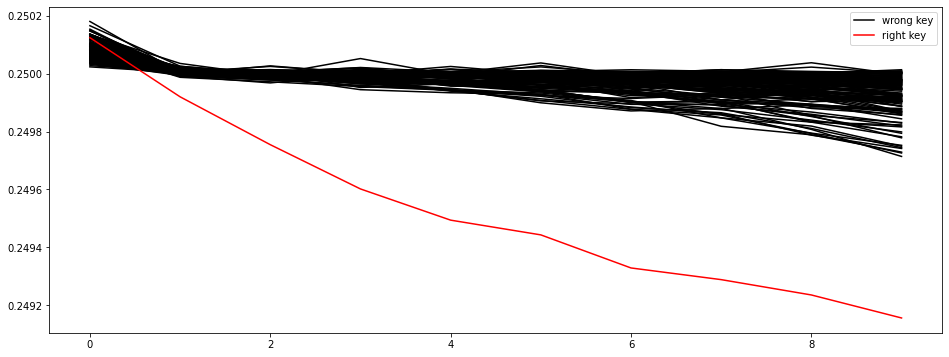

Right candidate:  0x2


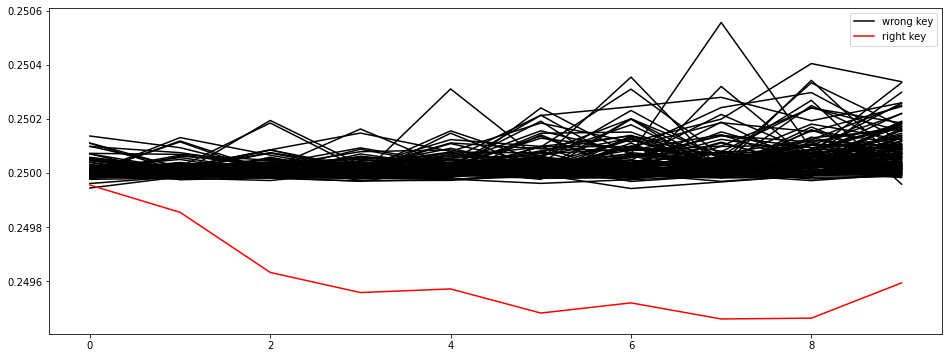

Training ended:  2022-08-18 15:07:14.562487
Elapsed 208.6702480316162


In [31]:
with tf.device("/device:GPU:0"):
    train_num = simul_trace_normal.shape[0]
    print(train_num)
    
    print("============= {} =============".format(train_num))
    rand_idx = np.arange(0, train_num) # 반복부분
    np.random.shuffle(rand_idx)
    
    simul_T_attack = simul_trace_normal[rand_idx]
    simul_P_attack = simul_pt[rand_idx]
    
    m = build_MLP_0(simul_trace_normal.shape[1])
    m.summary()
    m.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    Init = m.get_weights()
    
    # 학습 시작 시간 측정
    print("Training started: ", datetime.datetime.now())
    start = time.time()
    
    simul_analysis_MLP_AT(m, Init, simul_T_attack, simul_P_attack, train_num, 128, 'HW', 10, 50, 0xE0)
    
    # 학습 종료 시간 측정 및 소요 시간 계산
    elapsed = time.time() - start
    print("Training ended: ", datetime.datetime.now())
    print("Elapsed", elapsed)